In [6]:
# Import required libraries
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import missingno as msno
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [7]:
# Using Path for cross-platform compatibility
data_path = Path("../../data/LC_train.csv")
data_raw = pd.read_csv(data_path)

In [22]:
# Select categorical columns and display their unique value counts
categorical_cols = data_raw.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"\n{col}: {data_raw[col].nunique()} unique values")
    # print(data_raw[col].value_counts())



Student_IDs: 1943 unique values

Semester: 2 unique values

Degree_Type: 3 unique values

Class_Standing: 6 unique values

Major: 363 unique values

Expected_Graduation: 11 unique values

Course_Name: 308 unique values

Course_Number: 336 unique values

Course_Type: 73 unique values

Check_In_Date: 184 unique values

Check_In_Time: 814 unique values

Check_Out_Time: 785 unique values

Gender: 2 unique values


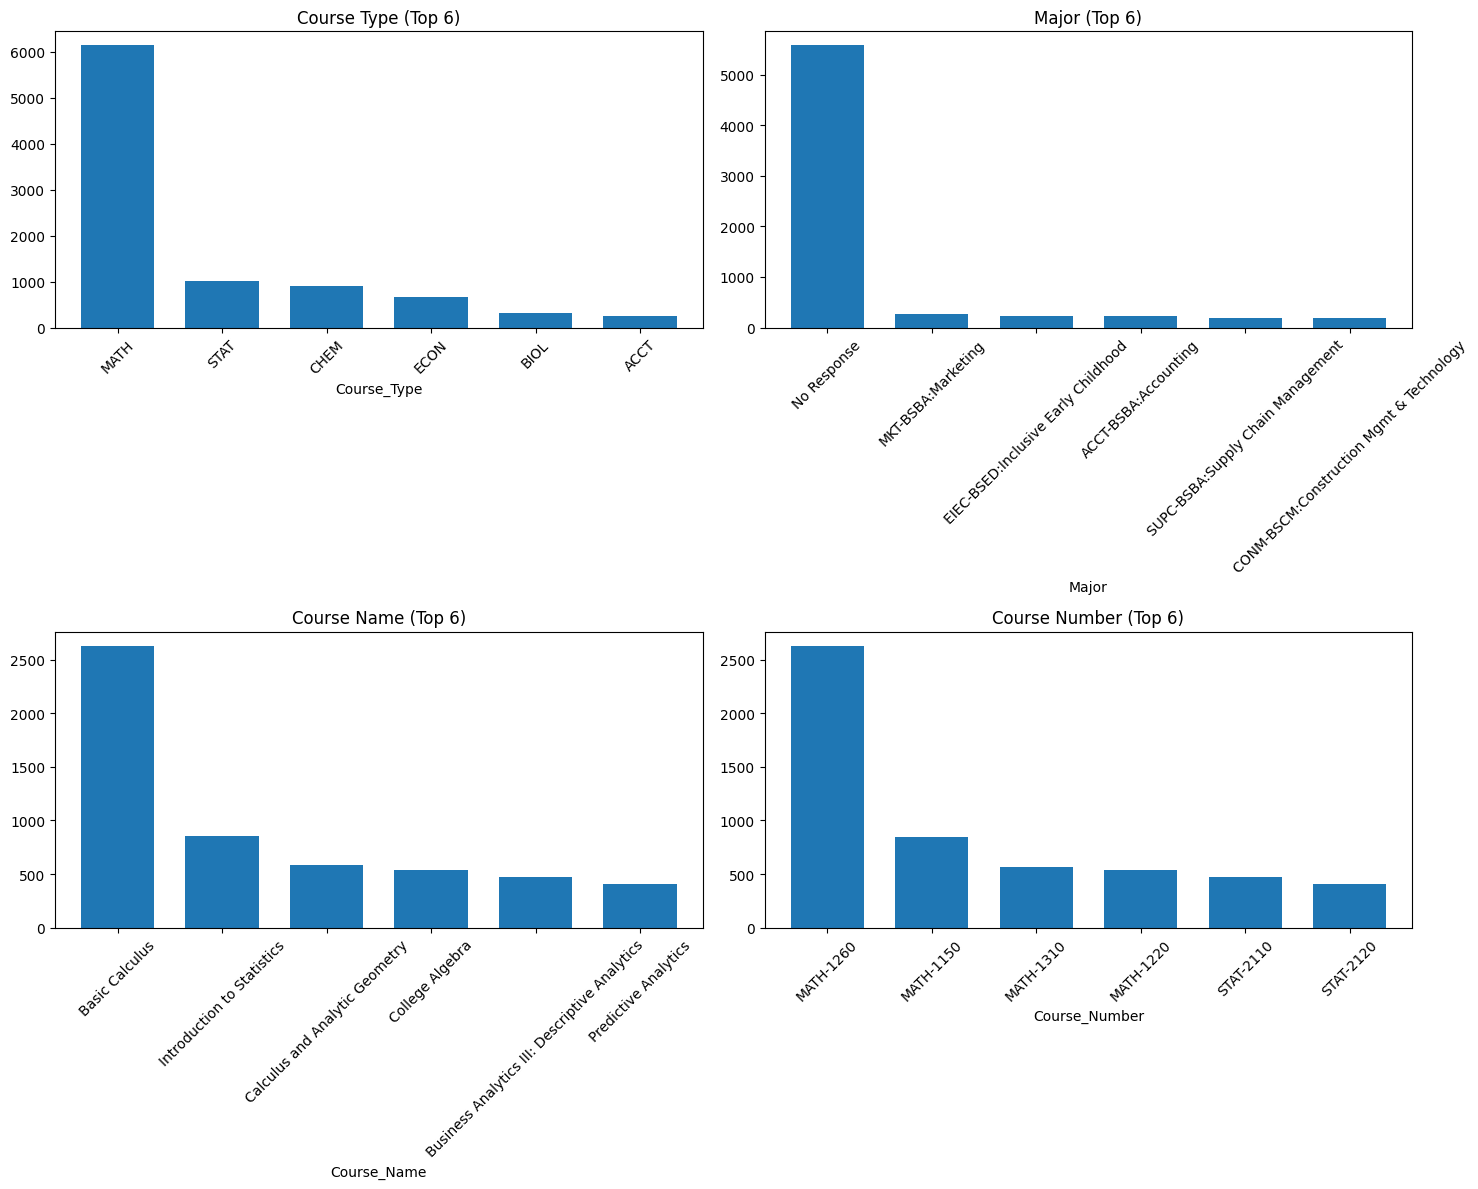

In [26]:
# Histograms of top 6 categories in major, course name, course number, course type
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Course Type
data_raw['Course_Type'].value_counts().head(6).plot(kind='bar', ax=axes[0,0], width=0.7)
axes[0,0].set_title('Course Type (Top 6)')
axes[0,0].tick_params(axis='x', rotation=45)

# Major
data_raw['Major'].value_counts().head(6).plot(kind='bar', ax=axes[0,1], width=0.7)
axes[0,1].set_title('Major (Top 6)')
axes[0,1].tick_params(axis='x', rotation=45)

# Course Name
data_raw['Course_Name'].value_counts().head(6).plot(kind='bar', ax=axes[1,0], width=0.7)
axes[1,0].set_title('Course Name (Top 6)')
axes[1,0].tick_params(axis='x', rotation=45)

# Course Number
data_raw['Course_Number'].value_counts().head(6).plot(kind='bar', ax=axes[1,1], width=0.7)
axes[1,1].set_title('Course Number (Top 6)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [28]:
print(data_raw['Course_Type'].value_counts())

Course_Type
MATH    6137
STAT    1006
CHEM     908
ECON     675
BIOL     321
        ... 
MUS        1
ECET       1
AHTH       1
ESHP       1
RESC       1
Name: count, Length: 73, dtype: int64


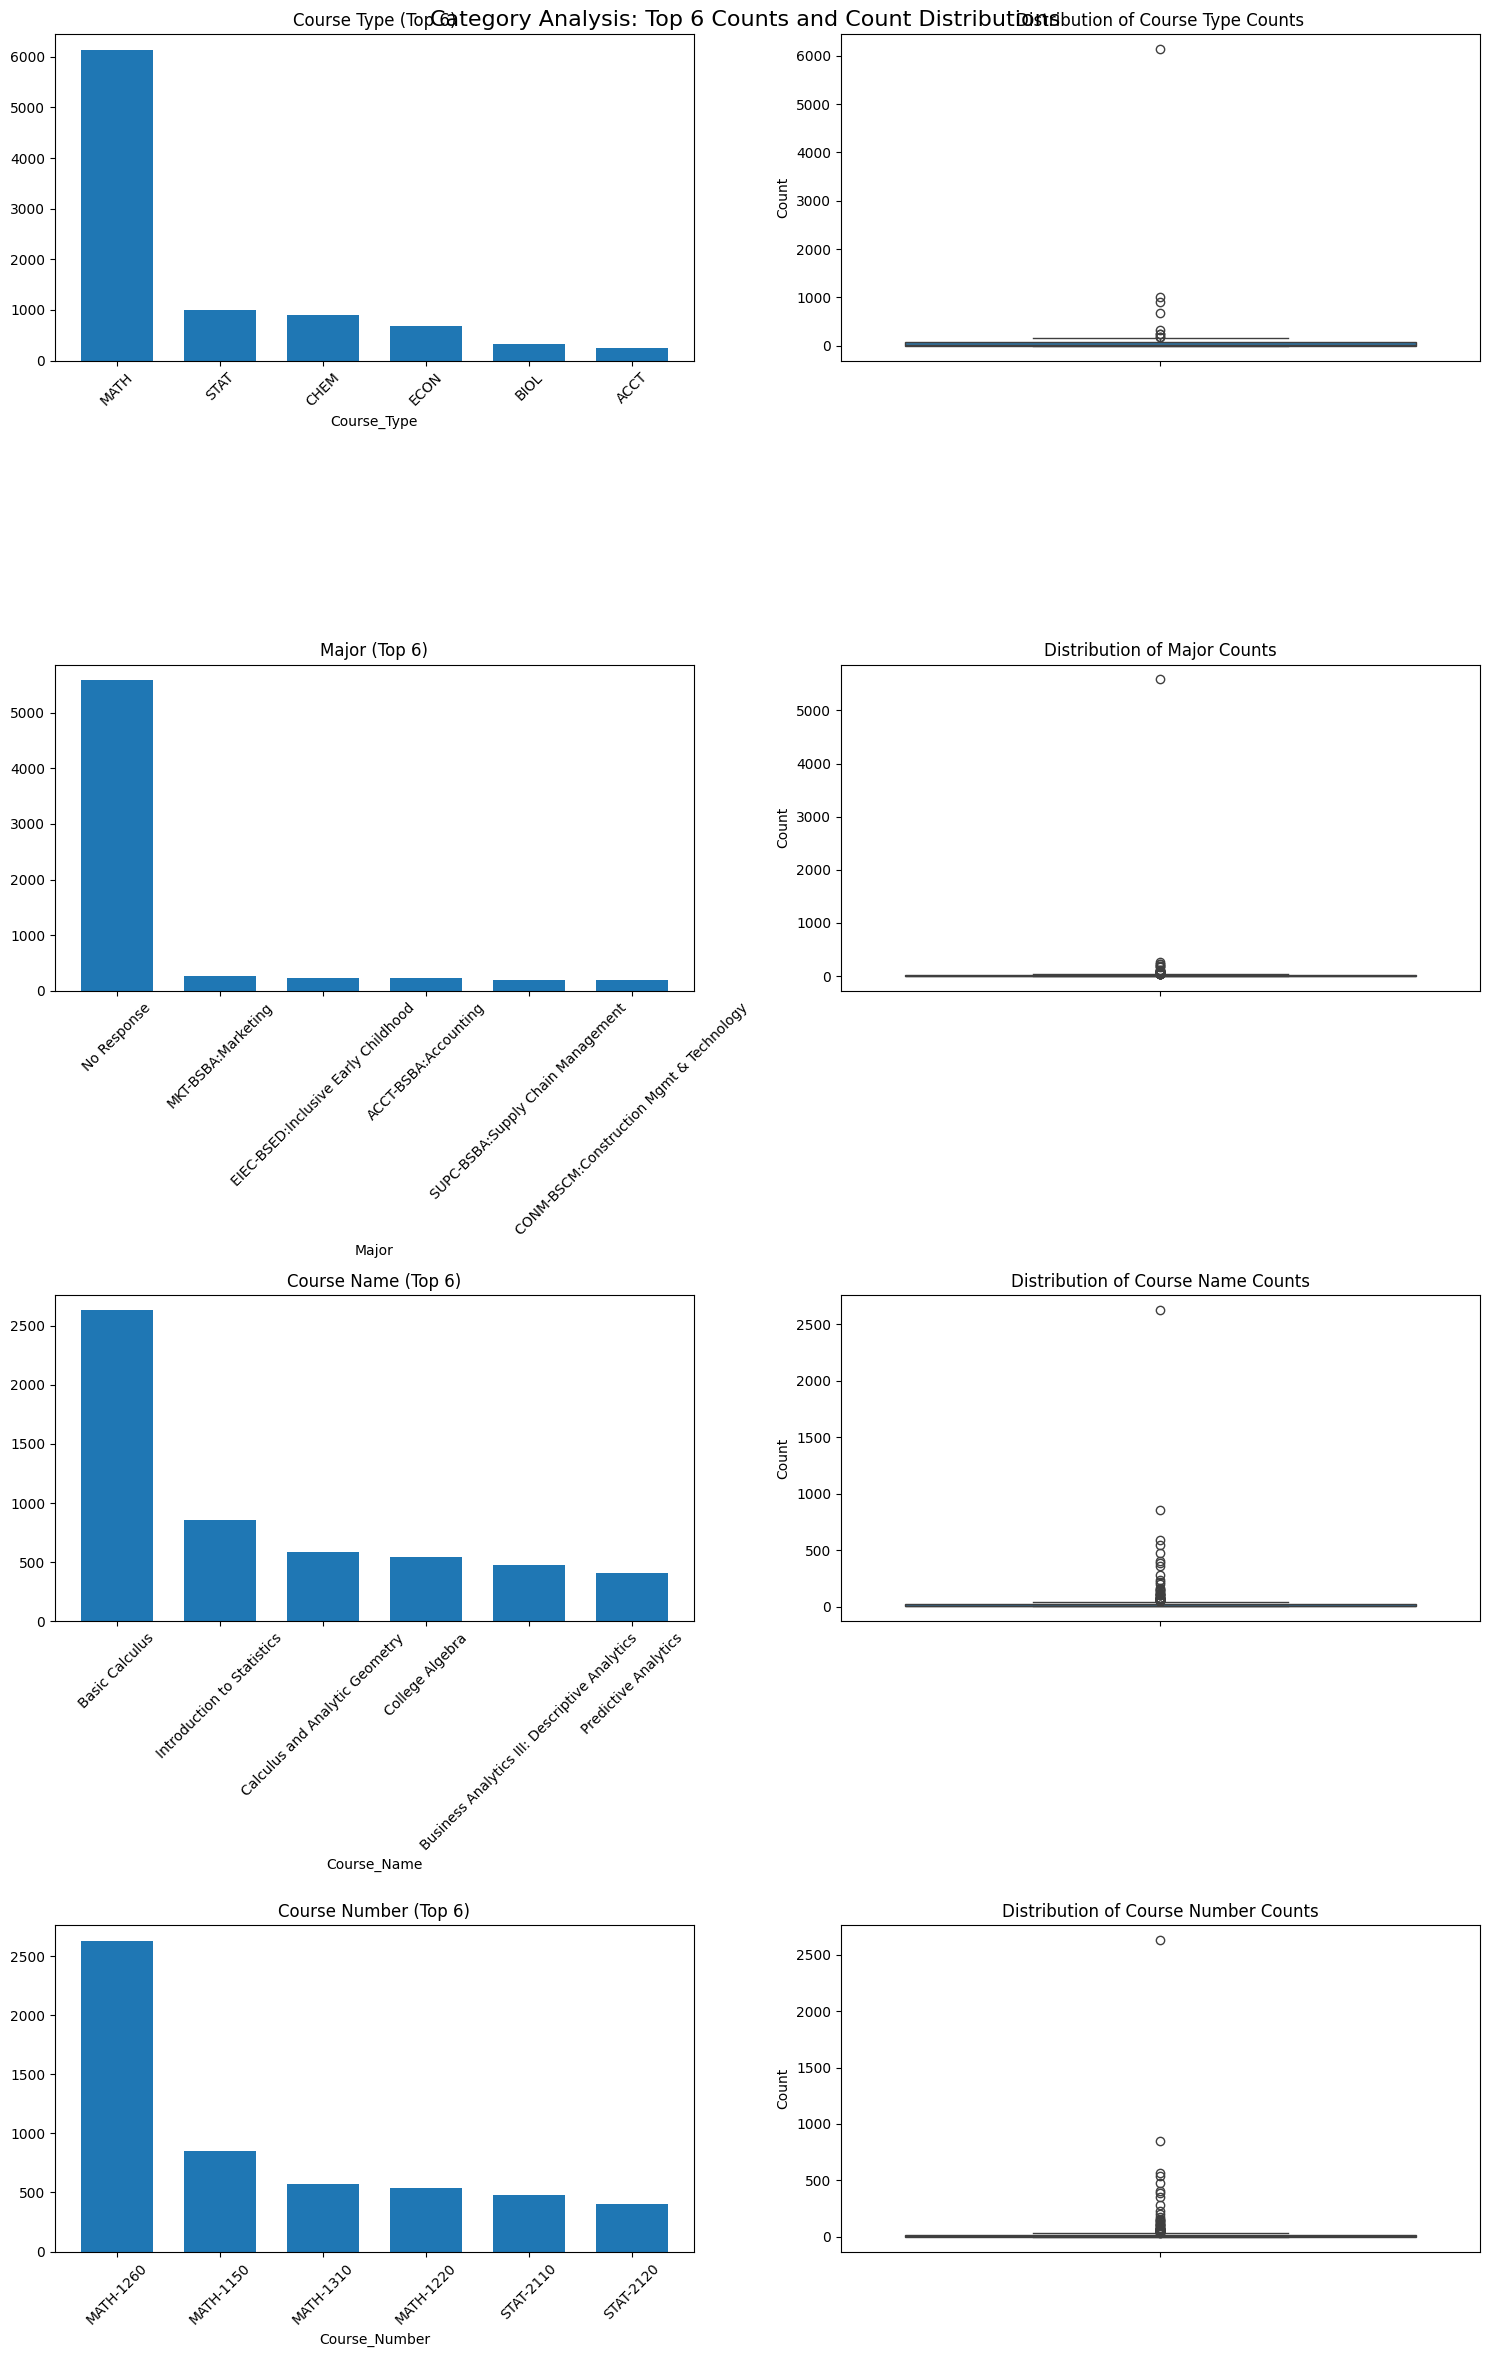

In [27]:
# Create two rows of subplots: bar plots and boxplots
fig, axes = plt.subplots(4, 2, figsize=(15, 24))
fig.suptitle('Category Analysis: Top 6 Counts and Count Distributions', fontsize=16)

# Bar plots (left column)
data_raw['Course_Type'].value_counts().head(6).plot(kind='bar', ax=axes[0,0], width=0.7)
axes[0,0].set_title('Course Type (Top 6)')
axes[0,0].tick_params(axis='x', rotation=45)

data_raw['Major'].value_counts().head(6).plot(kind='bar', ax=axes[1,0], width=0.7)
axes[1,0].set_title('Major (Top 6)')
axes[1,0].tick_params(axis='x', rotation=45)

data_raw['Course_Name'].value_counts().head(6).plot(kind='bar', ax=axes[2,0], width=0.7)
axes[2,0].set_title('Course Name (Top 6)')
axes[2,0].tick_params(axis='x', rotation=45)

data_raw['Course_Number'].value_counts().head(6).plot(kind='bar', ax=axes[3,0], width=0.7)
axes[3,0].set_title('Course Number (Top 6)')
axes[3,0].tick_params(axis='x', rotation=45)

# Boxplots of counts (right column)
sns.boxplot(y=data_raw['Course_Type'].value_counts(), ax=axes[0,1])
axes[0,1].set_title('Distribution of Course Type Counts')
axes[0,1].set_ylabel('Count')

sns.boxplot(y=data_raw['Major'].value_counts(), ax=axes[1,1])
axes[1,1].set_title('Distribution of Major Counts')
axes[1,1].set_ylabel('Count')

sns.boxplot(y=data_raw['Course_Name'].value_counts(), ax=axes[2,1])
axes[2,1].set_title('Distribution of Course Name Counts')
axes[2,1].set_ylabel('Count')

sns.boxplot(y=data_raw['Course_Number'].value_counts(), ax=axes[3,1])
axes[3,1].set_title('Distribution of Course Number Counts')
axes[3,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [8]:
# -----------------------------------------------------------------------------
# DATA PREPARATION
# -----------------------------------------------------------------------------
def prepare_dates(df):
    """Convert date and time columns to appropriate formats."""
    return df.assign(
        Check_In_Date=pd.to_datetime(df['Check_In_Date'], format='%m/%d/%y'),
        Check_In_Time=pd.to_datetime(df['Check_In_Time'], format='%H:%M:%S').dt.time,
        Check_Out_Time=pd.to_datetime(df['Check_Out_Time'], format='%H:%M:%S').dt.time,
    )
    
def add_temporal_features(df):
    """Add time-based features to the dataframe."""
    return df.assign(
        Day_of_Week=pd.to_datetime(df['Check_In_Date']).dt.day_name().str[:3],
        Is_Weekend=pd.to_datetime(df['Check_In_Date']).dt.dayofweek.isin([5, 6]),
        Week_of_Month=pd.to_datetime(df['Check_In_Date']).dt.day.apply(lambda x: np.ceil(x/7)),
        Month=pd.to_datetime(df['Check_In_Date']).dt.month_name().str[:3],
        Hour_of_Day=pd.to_datetime(df['Check_In_Time'], format='%H:%M:%S').dt.hour,
    )

In [9]:
# -----------------------------------------------------------------------------
# STUDY SESSION FEATURES
# -----------------------------------------------------------------------------
def add_session_features(df):
    """Add study session-related features."""
    duration = ((pd.to_datetime(df['Check_Out_Time'].astype(str), format='%H:%M:%S') - 
                pd.to_datetime(df['Check_In_Time'].astype(str), format='%H:%M:%S'))
               .dt.total_seconds() / 60)

    # Filter out negative durations
    df = df[duration >= 0].copy()
    duration = duration[duration >= 0]
    
    return df.assign(
        Duration_In_Min=duration,
        Session_Length_Category=pd.cut(
            duration,
            bins=[-np.inf, 30, 90, 180, np.inf],
            labels=['Short', 'Medium', 'Long', 'Extended']
        )
    )

def calculate_occupancy(group):
    """Calculate occupancy for a group of check-ins."""
    # Specify format for datetime conversion
    check_in_times = pd.to_datetime(group['Check_In_Time'].astype(str), format='%H:%M:%S')
    check_out_times = pd.to_datetime(group['Check_Out_Time'].astype(str), format='%H:%M:%S')
    
    arrivals = range(1, len(group) + 1)
    departures = [
        sum(1 for j in range(i + 1)
            if not pd.isna(check_out_times.iloc[j]) 
            and check_out_times.iloc[j] <= check_in_times.iloc[i])
        for i in range(len(group))
    ]
    
    return [a - d for a, d in zip(arrivals, departures)]

def add_occupancy(df):
    """Add occupancy calculations to the dataframe."""
    df = df.sort_values(['Check_In_Date', 'Check_In_Time'])
    return df.assign(
        Occupancy=df.groupby('Check_In_Date', group_keys=False)
                    .apply(calculate_occupancy, include_groups=False)
                    .explode()
                    .values
    )

In [10]:
# -----------------------------------------------------------------------------
# PIPELINE FEATURES
# -----------------------------------------------------------------------------
def engineer_features(df):
    """Apply all feature engineering transformations."""
    return (df
            .pipe(prepare_dates)
            .pipe(add_temporal_features)
            .pipe(add_session_features)
            .pipe(add_occupancy)
    )

# Process the data
lc_engineered = engineer_features(data_raw)

In [11]:
lc_engineered['Duration_In_Min'].describe()

count    11734.000000
mean        82.233339
std         62.022875
min          6.000000
25%         45.000000
50%         68.000000
75%        104.000000
max        822.000000
Name: Duration_In_Min, dtype: float64

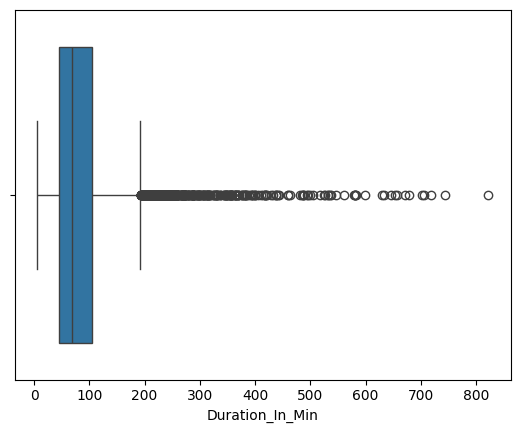

In [12]:
sns.boxplot(x='Duration_In_Min', data=lc_engineered)
plt.show()

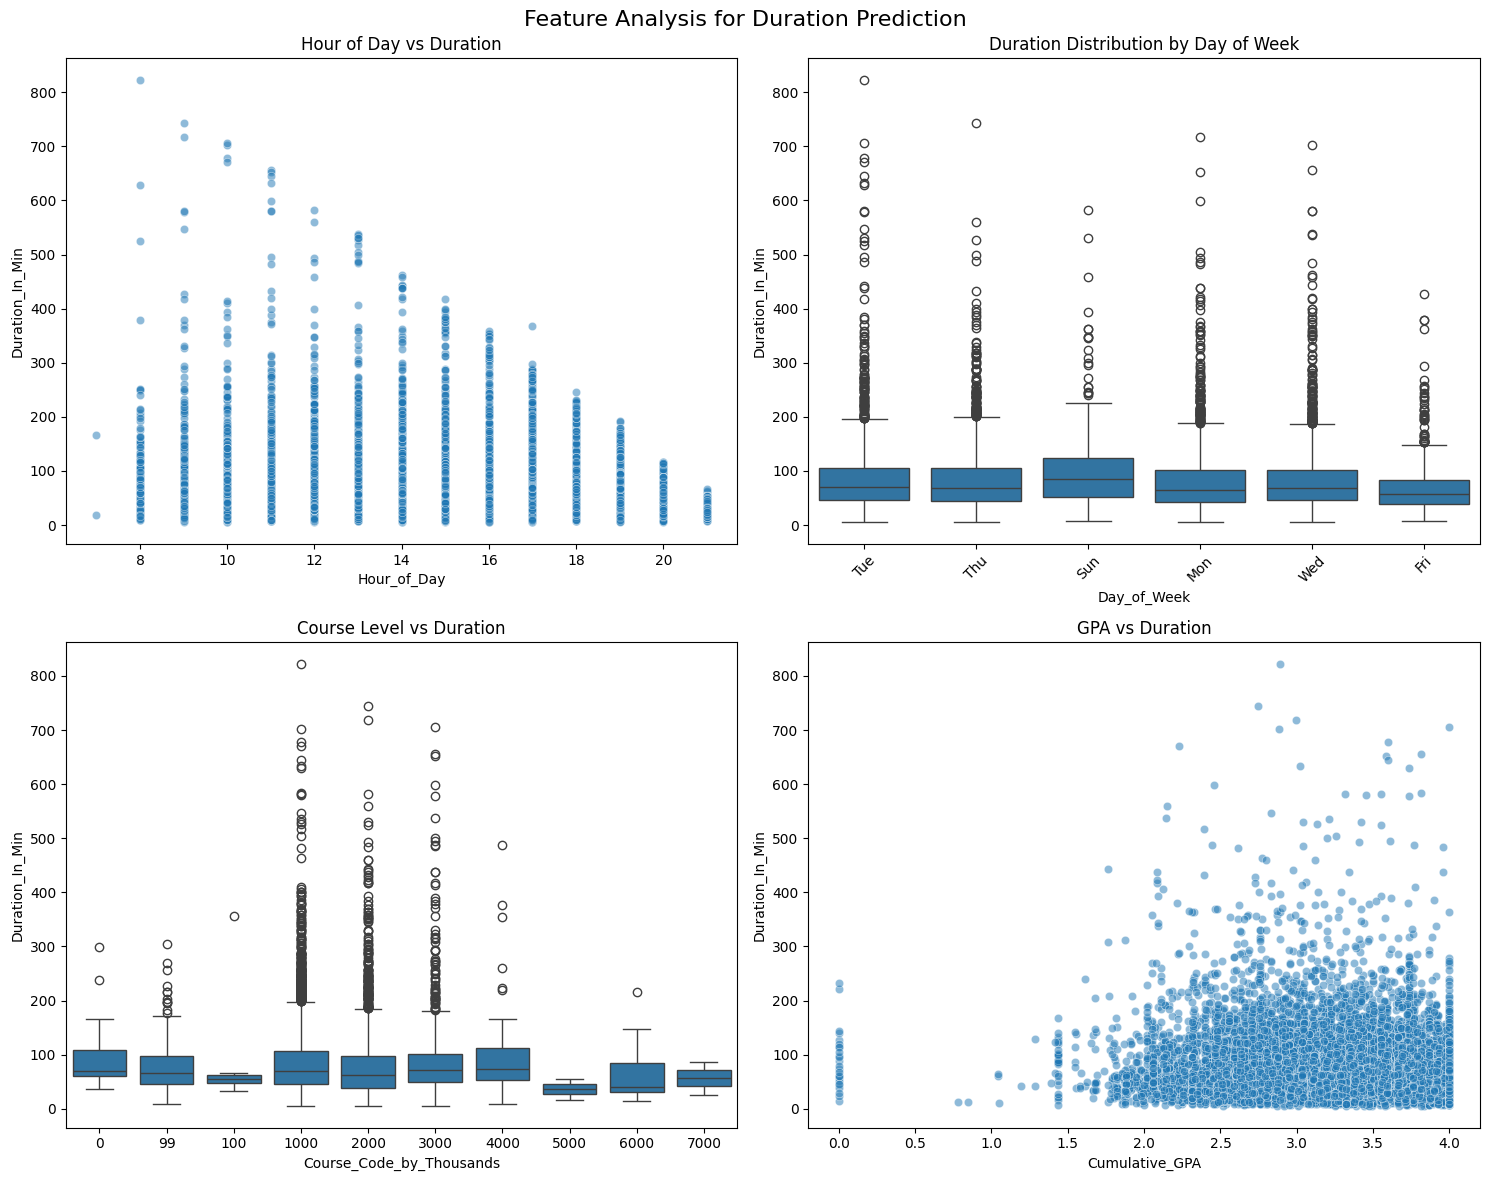

In [14]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Feature Analysis for Duration Prediction', fontsize=16)

# 1. Time of Day vs Duration
sns.scatterplot(
    data=lc_engineered,
    x='Hour_of_Day',
    y='Duration_In_Min',
    alpha=0.5,
    ax=axes[0,0]
)
axes[0,0].set_title('Hour of Day vs Duration')

# 2. Box plot of Duration by Day of Week
sns.boxplot(
    data=lc_engineered,
    x='Day_of_Week',
    y='Duration_In_Min',
    ax=axes[0,1]
)
axes[0,1].set_title('Duration Distribution by Day of Week')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Course Level (thousands) vs Duration
sns.boxplot(
    data=lc_engineered,
    x='Course_Code_by_Thousands',
    y='Duration_In_Min',
    ax=axes[1,0]
)
axes[1,0].set_title('Course Level vs Duration')

# 4. GPA vs Duration
sns.scatterplot(
    data=lc_engineered,
    x='Cumulative_GPA',
    y='Duration_In_Min',
    alpha=0.5,
    ax=axes[1,1]
)
axes[1,1].set_title('GPA vs Duration')

plt.tight_layout()
plt.show()

In [15]:
# Calculate correlations with Duration_In_Min for numeric columns
numeric_cols = lc_engineered.select_dtypes(include=['float64', 'int64']).columns
correlations = lc_engineered[numeric_cols].corr()['Duration_In_Min'].sort_values(ascending=False)
print("\nCorrelations with Duration_In_Min:")
print(correlations)


Correlations with Duration_In_Min:
Duration_In_Min              1.000000
Total_Credit_Hours_Earned    0.038508
Semester_Week                0.031792
Week_of_Month                0.002907
Course_Code_by_Thousands    -0.007637
Change_in_GPA               -0.017040
Cumulative_GPA              -0.036242
Term_GPA                    -0.039300
Term_Credit_Hours           -0.059010
Name: Duration_In_Min, dtype: float64


In [17]:
def add_advanced_features(df):
    """Add more sophisticated engineered features."""
    
    # Time-based features
    df['Time_Block'] = pd.cut(
        df['Hour_of_Day'],
        bins=[0, 11, 16, 23],
        labels=['Morning', 'Afternoon', 'Evening']
    )
    df['Is_Peak_Hours'] = df['Hour_of_Day'].between(11, 16)
    
    # Course-related features
    df['Is_STEM'] = df['Course_Type'].isin(['MATH', 'STAT', 'COMPSC'])
    df['Course_Level'] = pd.cut(
        df['Course_Code_by_Thousands'],
        bins=[0, 1000, 2000, 3000, 4000],
        labels=['Intro', 'Basic', 'Intermediate', 'Advanced']
    )
    
    # Academic performance features
    df['GPA_Bracket'] = pd.qcut(
        df['Cumulative_GPA'],
        q=4,
        labels=['Low', 'Medium-Low', 'Medium-High', 'High']
    )
    df['GPA_Change'] = df['Term_GPA'] - df['Cumulative_GPA']
    df['Credit_GPA_Interaction'] = df['Term_Credit_Hours'] * df['Cumulative_GPA']
    
    # Student study patterns
    student_avg_duration = df.groupby('Student_IDs')['Duration_In_Min'].transform('mean')
    df['Above_Average_Duration'] = df['Duration_In_Min'] > student_avg_duration
    
    return df

# Add the new features
lc_engineered = lc_engineered.pipe(add_advanced_features)

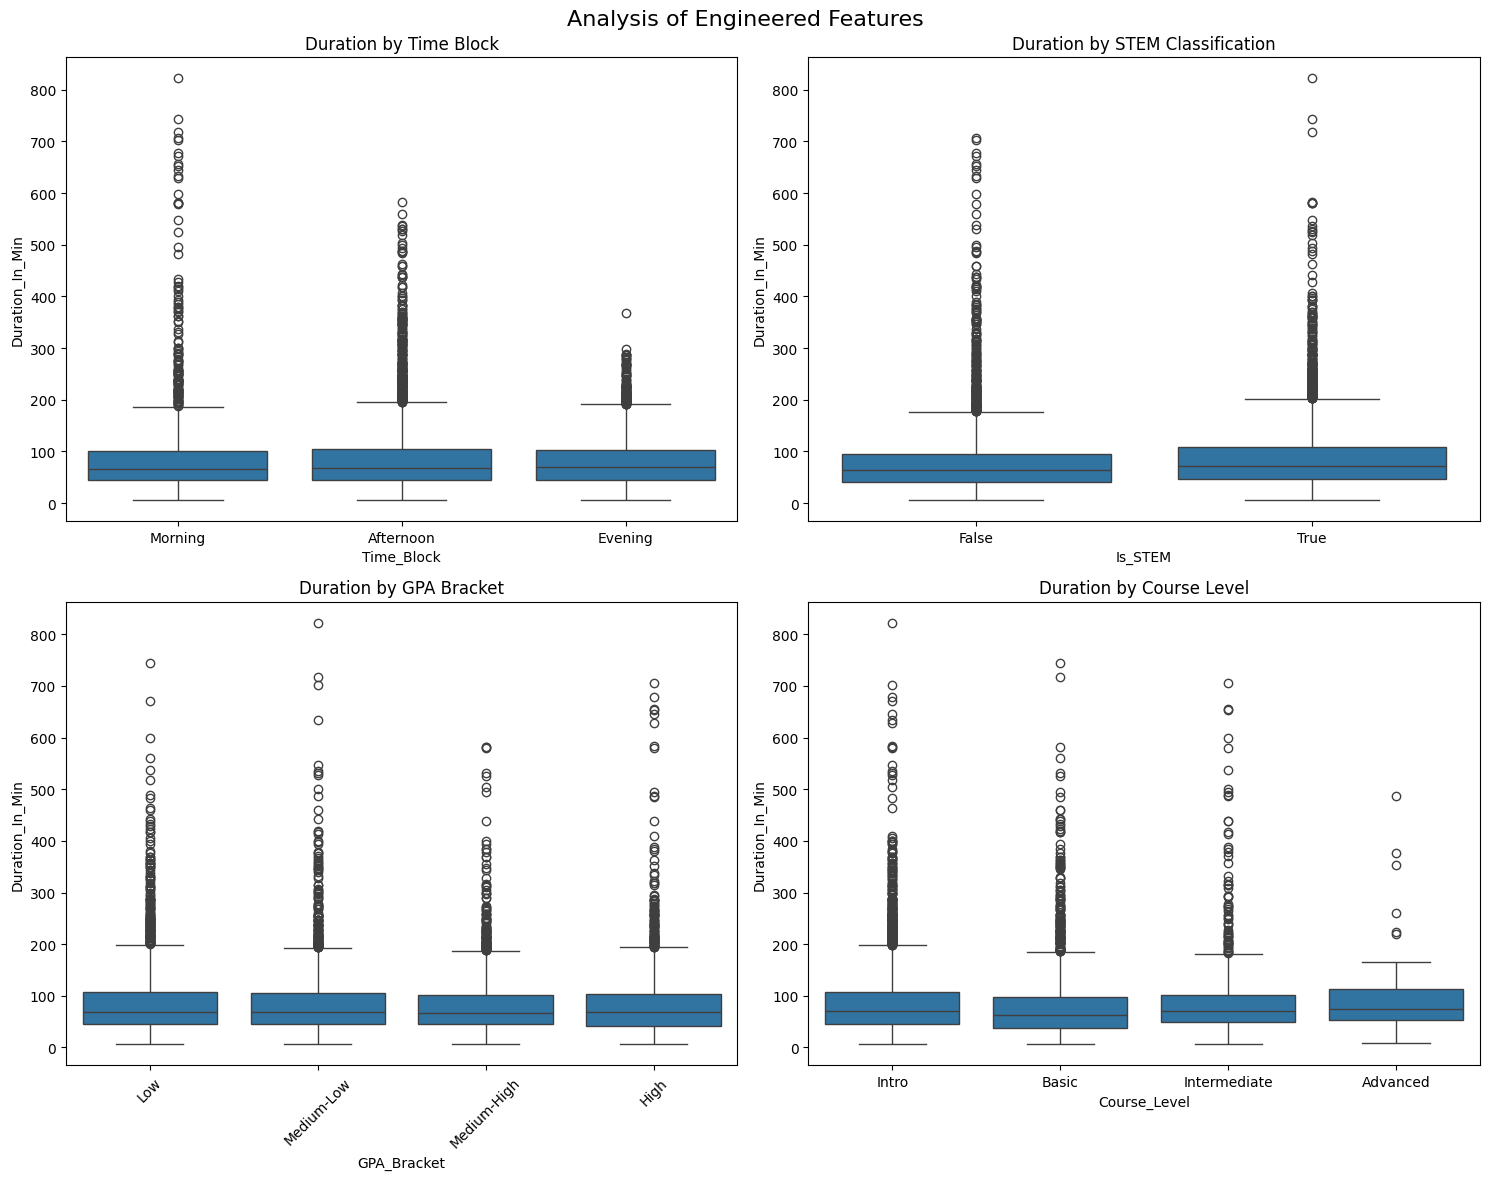

In [18]:
# Show the impact of some new features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analysis of Engineered Features', fontsize=16)

# 1. Time Block vs Duration
sns.boxplot(
    data=lc_engineered,
    x='Time_Block',
    y='Duration_In_Min',
    ax=axes[0,0]
)
axes[0,0].set_title('Duration by Time Block')

# 2. STEM vs Non-STEM
sns.boxplot(
    data=lc_engineered,
    x='Is_STEM',
    y='Duration_In_Min',
    ax=axes[0,1]
)
axes[0,1].set_title('Duration by STEM Classification')

# 3. GPA Bracket vs Duration
sns.boxplot(
    data=lc_engineered,
    x='GPA_Bracket',
    y='Duration_In_Min',
    ax=axes[1,0]
)
axes[1,0].set_title('Duration by GPA Bracket')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Course Level vs Duration
sns.boxplot(
    data=lc_engineered,
    x='Course_Level',
    y='Duration_In_Min',
    ax=axes[1,1]
)
axes[1,1].set_title('Duration by Course Level')

plt.tight_layout()
plt.show()

In [20]:
# Select categorical columns and display their unique value counts
categorical_cols = lc_engineered.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"\n{col}: {lc_engineered[col].nunique()} unique values")
    # print(lc_engineered[col].value_counts())


Student_IDs: 1943 unique values

Semester: 2 unique values

Degree_Type: 3 unique values

Class_Standing: 6 unique values

Major: 363 unique values

Expected_Graduation: 11 unique values

Course_Name: 308 unique values

Course_Number: 336 unique values

Course_Type: 73 unique values

Check_In_Time: 814 unique values

Check_Out_Time: 784 unique values

Gender: 2 unique values

Day_of_Week: 6 unique values

Month: 10 unique values

Session_Length_Category: 4 unique values

Occupancy: 40 unique values

Time_Block: 3 unique values

Course_Level: 4 unique values

GPA_Bracket: 4 unique values
